# Hybrid Manufacturing EDA 목차

본 EDA는 모델링 목적이 아니라,
Snowflake 기반 Medallion Architecture에서
Bronze·Silver·Gold 단계 설계를 검증하기 위해 수행

---

## 1. 데이터 개요

- **데이터 출처**: Kaggle
- **데이터 설명**:  
  적층 및 절삭 가공 공정을 통합한  
  **하이브리드 제조 시스템(HMS)**
  의 생산 계획 및 최적화 데이터

---

## 2. 데이터 구조 및 스키마 탐색

- 컬럼 구성 및 데이터 타입 확인
- 수치형 / 범주형 / 시간형 컬럼 분류
- **Bronze CSV 테이블 구조 설계 기반 확보**

---

## 3. 데이터 품질 점검 (Data Quality)

- 결측값 및 중복 데이터 확인
- **Silver 단계 정제 대상 사전 식별**

---

## 4. 변수 간 관계 탐색

- 주요 변수 간 상관 관계 분석
- 기계/공정별 패턴 비교
- **Gold 단계 KPI 설계를 위한 인사이트 도출**


In [51]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# 데이터 구조 및 스키마 탐색
df = pd.read_csv(r"F:\sample_data\csv\hybrid_manufacturing_categorical.csv")
df.head()

,Job_ID,Machine_ID,Operation_Type,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability,Scheduled_Start,Scheduled_End,Actual_Start,Actual_End,Job_Status,Optimization_Category
0,J001,M01,Grinding,3.17,76,11.42,96,2023-03-18 8:00,2023-03-18 9:16,2023-03-18 8:05,2023-03-18 9:21,Completed,Moderate Efficiency
1,J002,M01,Grinding,3.35,79,6.61,84,2023-03-18 8:10,2023-03-18 9:29,2023-03-18 8:20,2023-03-18 9:39,Delayed,Low Efficiency
2,J003,M04,Additive,2.29,56,11.11,92,2023-03-18 8:20,2023-03-18 9:16,NaN,NaN,Failed,Low Efficiency
3,J004,M04,Grinding,1.76,106,12.50,95,2023-03-18 8:30,2023-03-18 10:16,2023-03-18 8:35,2023-03-18 10:21,Completed,Moderate Efficiency
4,J005,M01,Lathe,1.90,46,8.13,88,2023-03-18 8:40,2023-03-18 9:26,2023-03-18 8:42,2023-03-18 9:28,Completed,High Efficiency


# 데이터 구조
- Job_ID : 작업 식별자
- Machine_ID : 해당 작업이 수행된 기계의 식별자
- Operation_Type : 공정 유형
- Material_Used : 사용된 재료의 양
- Processing_Time : 작업 처리 시간
- Energy_Consumption : 에너지 소비량
- Machine_Availability : 기계 가용성
- Scheduled_Start : 예정 시작 시간
- Scheduled_End : 예정 종료 시간
- Actual_Start : 실제 시작 시간
- Actual_End : 실제 종료 시간
- Job_Status : 작업 상태 (예: 완료, 지연 등)
- Optimization_Category : 최적화 범주 (예: 효율성 수준 등)

## Data Profiling 기반 컬럼별 Snowflake 추천 데이터 타입

> 본 데이터 타입은 OpenAI 기반 Data Profiling 결과로 도출된 **Snowflake 추천 데이터 타입**이며,  
> 실제 Snowflake 적재 전 데이터 분포 및 값 범위를 기준으로 **검증 후 확정**

| 컬럼명 | 추천 데이터 타입 | 비고 |
|------|------------------|------|
| Job_ID | VARCHAR(10) | 작업 식별자 |
| Machine_ID | VARCHAR(3) | 해당 작업이 수행된 기계의 식별자 |
| Operation_Type | VARCHAR(50) | 공정 유형 |
| Material_Used | VARCHAR(10) | 사용된 재료의 양 |
| Processing_Time | INTEGER | 작업 처리 시간 |
| Energy_Consumption | FLOAT | 에너지 소비량 |
| Machine_Availability | VARCHAR(3) |  기계 가용성 |
| Scheduled_Start | TIMESTAMP_NTZ | 예정 시작 시간 |
| Scheduled_End | TIMESTAMP_NTZ | 예정 종료 시간 |
| Actual_Start | TIMESTAMP_NTZ | 실제 시작 시간 |
| Actual_End | TIMESTAMP_NTZ | 실제 종료 시간 |
| Job_Status | VARCHAR(50) | 작업 상태 |
| Optimization_Category | VARCHAR(50) | 최적화 범주 |


In [5]:
# Data Profiling 컬럼볍 추천 데이터 VS 원본 데이터 비교
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_ID                 1000 non-null   object 
 1   Machine_ID             1000 non-null   object 
 2   Operation_Type         1000 non-null   object 
 3   Material_Used          1000 non-null   float64
 4   Processing_Time        1000 non-null   int64  
 5   Energy_Consumption     1000 non-null   float64
 6   Machine_Availability   1000 non-null   int64  
 7   Scheduled_Start        1000 non-null   object 
 8   Scheduled_End          1000 non-null   object 
 9   Actual_Start           871 non-null    object 
 10  Actual_End             871 non-null    object 
 11  Job_Status             1000 non-null   object 
 12  Optimization_Category  1000 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 101.7+ KB


## 데이터 타입 불일치 컬럼 검증 대상

원본 데이터의 dtype과 사전 정의한 Snowflake 데이터 타입을 비교한 결과,  
다음 컬럼에서 **타입 불일치가 확인되어 추가 검증 대상으로 지정**

| 컬럼명 | 원본 dtype | Snowflake 추천 타입 |
|------|------------|---------------------|
| Material_Used | float64 | VARCHAR(10) |
| Machine_Availability | int64 | VARCHAR(3) |
| Scheduled_Start | object | TIMESTAMP_NTZ |
| Scheduled_End | object | TIMESTAMP_NTZ |
| Actual_Start | object | TIMESTAMP_NTZ |
| Actual_End | object | TIMESTAMP_NTZ |


In [16]:
# dtype 불일치 컬럼에 대한 실제 값 검증
df[["Material_Used", "Machine_Availability", "Scheduled_Start", "Scheduled_End", "Actual_Start", "Actual_End"]]

,Material_Used,Machine_Availability,Scheduled_Start,Scheduled_End,Actual_Start,Actual_End
0,3.17,96,2023-03-18 8:00,2023-03-18 9:16,2023-03-18 8:05,2023-03-18 9:21
1,3.35,84,2023-03-18 8:10,2023-03-18 9:29,2023-03-18 8:20,2023-03-18 9:39
2,2.29,92,2023-03-18 8:20,2023-03-18 9:16,NaN,NaN
3,1.76,95,2023-03-18 8:30,2023-03-18 10:16,2023-03-18 8:35,2023-03-18 10:21
4,1.90,88,2023-03-18 8:40,2023-03-18 9:26,2023-03-18 8:42,2023-03-18 9:28
...,...,...,...,...,...,...
995,4.86,97,2023-03-25 5:50,2023-03-25 6:40,NaN,NaN
996,2.72,96,2023-03-25 6:00,2023-03-25 7:00,NaN,NaN
997,1.31,83,2023-03-25 6:10,2023-03-25 7:52,2023-03-25 6:15,2023-03-25 7:57
998,2.40,83,2023-03-25 6:20,2023-03-25 7:35,2023-03-25 6:24,2023-03-25 7:39


## 최종 Snowflake Dtype
| 컬럼명 | 데이터 타입 |
|------|-------------|
| Job_ID | VARCHAR(10) |
| Machine_ID | VARCHAR(10) |
| Operation_Type | VARCHAR(100) |
| Material_Used | NUMBER(10,2) |
| Processing_Time | NUMBER(10,0) |
| Energy_Consumption | NUMBER(10,2) |
| Machine_Availability | NUMBER(10,0) |
| Scheduled_Start | TIMESTAMP_NTZ |
| Scheduled_End | TIMESTAMP_NTZ |
| Actual_Start | TIMESTAMP_NTZ |
| Actual_End | TIMESTAMP_NTZ |
| Job_Status | VARCHAR(100) |
| Optimization_Category | VARCHAR(100) |

## Medallion Architecture 설계를 위한 EDA

### Bronze Layer
- 원본 데이터를 **변형 없이 그대로 적재**
- Snowflake 적재를 위한 **데이터 타입 지정 및 스키마 정의** 수행

---

### Silver Layer
- 컬럼 정제 및 데이터 변환 수행
- 본 단계에서는 **데이터 파악 및 EDA까지만 진행**
- 실제 정제·변환 로직은 **Snowflake 기반으로 처리 예정**

---

### Gold Layer
- 분석 및 시각화 목적의 데이터 마트 구성
- Data Profiling & EDA 결과를 기반으로  
  **상관관계 분석 및 KPI 시각화 설계 진행**


In [6]:
# 컬럼별 고유값 분포 분석
df.nunique()

Job_ID                   1000
Machine_ID                  5
Operation_Type              5
Material_Used             362
Processing_Time           101
Energy_Consumption        702
Machine_Availability       20
Scheduled_Start          1000
Scheduled_End             955
Actual_Start              851
Actual_End                834
Job_Status                  3
Optimization_Category       4
dtype: int64

In [133]:
# 범주형 데이터 파악
def inspect_all_columns(df, top_n=10):
    for col in df[["Machine_ID", "Operation_Type","Optimization_Category", "Job_Status"]]:
        print("=" * 80)
        print(f"Column: {col}")
        print(f"dtype: {df[col].dtype}")
        print(f"total_count: {len(df)}")
        print(f"non_null_count: {df[col].notna().sum()}")
        print(f"null_count: {df[col].isna().sum()}")
        print(f"nunique: {df[col].nunique()}")

        print("\nvalue_counts:")
        print(df[col].value_counts(dropna=False).head(top_n))
        print()
        
inspect_all_columns(df)

Column: Machine_ID
dtype: object
total_count: 1000
non_null_count: 1000
null_count: 0
nunique: 5

value_counts:
Machine_ID
M01    212
M02    210
M04    199
M05    193
M03    186
Name: count, dtype: int64

Column: Operation_Type
dtype: object
total_count: 1000
non_null_count: 1000
null_count: 0
nunique: 5

value_counts:
Operation_Type
Lathe       212
Grinding    208
Milling     201
Additive    190
Drilling    189
Name: count, dtype: int64

Column: Optimization_Category
dtype: object
total_count: 1000
non_null_count: 1000
null_count: 0
nunique: 4

value_counts:
Optimization_Category
Low Efficiency         650
Moderate Efficiency    183
High Efficiency        161
Optimal Efficiency       6
Name: count, dtype: int64

Column: Job_Status
dtype: object
total_count: 1000
non_null_count: 1000
null_count: 0
nunique: 3

value_counts:
Job_Status
Completed    673
Delayed      198
Failed       129
Name: count, dtype: int64



In [38]:
# 수치형 데이터 통계값 확인
df.describe()

,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,3.026480,71.38400,8.521340,89.163000
std,1.148139,28.48438,3.669941,5.757567
min,1.010000,20.00000,2.010000,80.000000
25%,2.040000,48.00000,5.397500,84.000000
50%,3.080000,72.00000,8.560000,89.000000
75%,4.042500,96.00000,11.672500,94.000000
max,5.000000,120.00000,14.980000,99.000000


# EDA 진행

---

## 1. 공정 유형(Operation_Type)과 기계 식별자(Machine_ID) 간 구조 관계 분석

### 분석 질문
- Operation_Type에 따라 Machine_ID가 고정적으로 매핑되는 구조인가?
- 또는 Machine_ID가 여러 Operation_Type을 수행하는 구조인가?

### 분석 항목
- Machine_ID별 Operation_Type 분포 확인
- Operation_Type별 수치형 컬럼 평균 및 분포 비교
- Machine_ID별 Optimization_Category 분포 확인

---

## 2. 실제 작업 시간(Actual_Start) 결측치 분석

### 분석 질문
- Actual_Start ~ Actual_End 컬럼의 결측치는 어떤 조건에서 발생하는가?
- 특정 작업 상태(Job_Status) 또는 공정과 연관되어 있는가?

### 분석 항목
- Actual_Start 컬럼 결측 비율 확인
- Job_Status / Operation_Type 기준 결측 분포 비교
- 결측치 처리(제외/대체) 가능 여부 검토

In [65]:
# 1. 공정 유형(Operation_Type)과 기계 식별자(Machine_ID) 간 구조 관계 분석
df.groupby('Machine_ID')['Operation_Type'].value_counts()

Machine_ID  Operation_Type
M01         Grinding          54
            Milling           45
            Additive          40
            Drilling          40
            Lathe             33
M02         Drilling          47
            Lathe             47
            Additive          40
            Grinding          39
            Milling           37
M03         Lathe             60
            Grinding          36
            Milling           31
            Additive          30
            Drilling          29
M04         Grinding          43
            Milling           43
            Drilling          39
            Lathe             38
            Additive          36
M05         Milling           45
            Additive          44
            Grinding          36
            Drilling          34
            Lathe             34
Name: count, dtype: int64

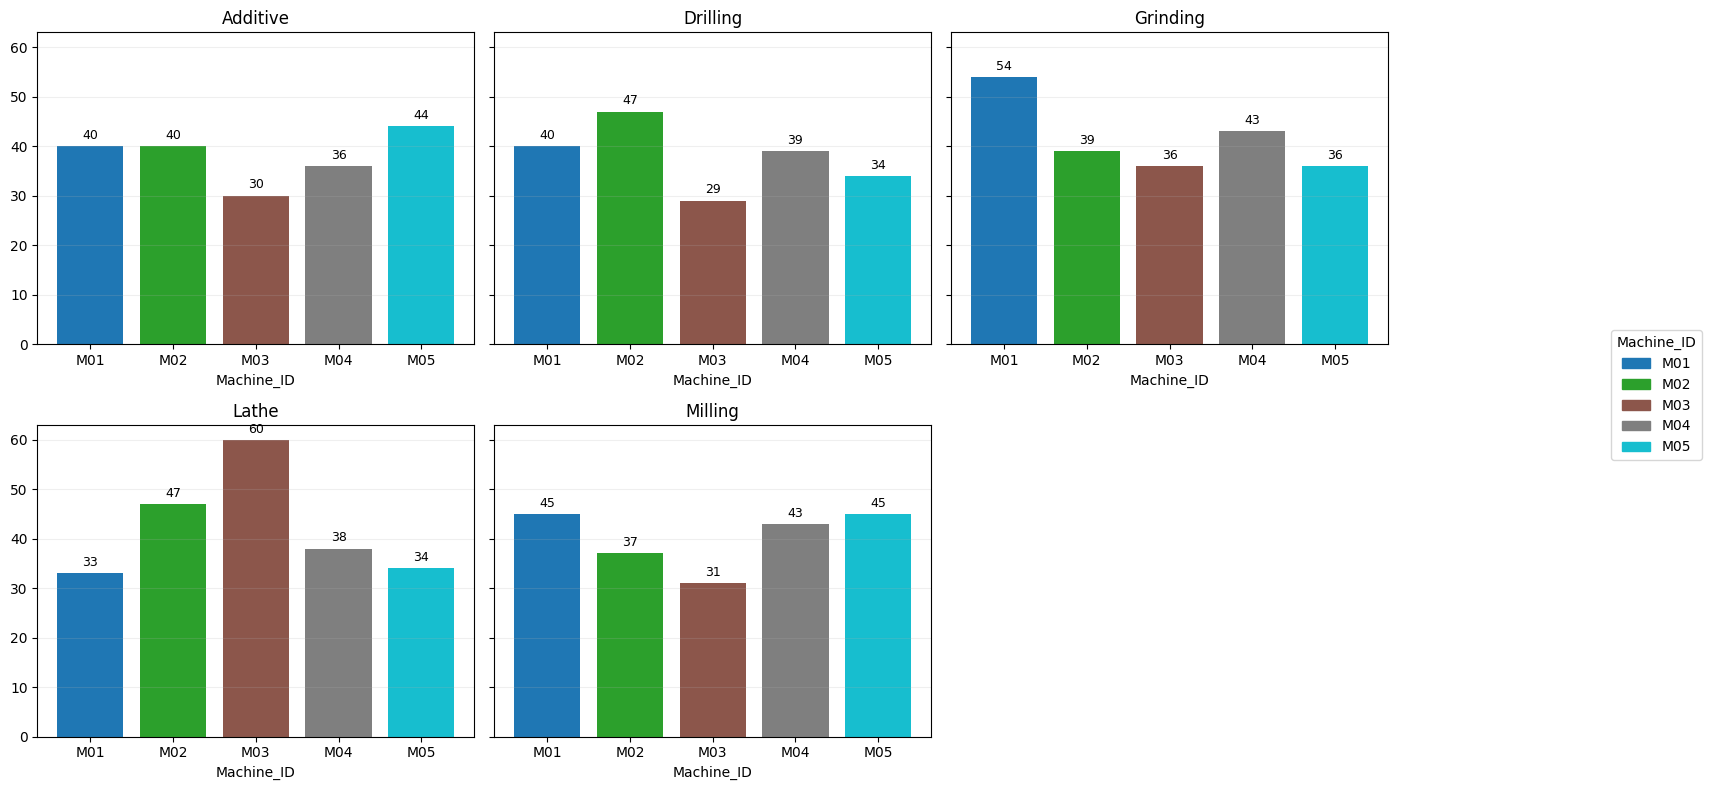

In [58]:
# 공정 유형(Operation_Type)과 기계 식별자(Machine_ID) 간 구조 관계 시각화
# 1) 집계
ct = pd.crosstab(df["Operation_Type"], df["Machine_ID"])

ops = ct.index.tolist()
machines = ct.columns.tolist()

# 2) subplot 레이아웃 자동 (공정 개수에 따라)
n_ops = len(ops)
ncols = 3
nrows = int(np.ceil(n_ops / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows), sharey=True)
axes = np.array(axes).reshape(-1)

# 3) Machine_ID별 색상 고정 (모든 subplot에서 동일 색)
cmap = plt.get_cmap("tab10", len(machines))
color_map = {m: cmap(i) for i, m in enumerate(machines)}

# 4) 공정별 bar 그리기
for i, op in enumerate(ops):
    ax = axes[i]
    s = ct.loc[op]  # Machine_ID별 count (Series)

    bars = ax.bar(
        s.index.astype(str),
        s.values,
        color=[color_map[m] for m in s.index]
    )

    ax.set_title(op)
    ax.set_xlabel("Machine_ID")
    ax.grid(axis="y", alpha=0.2)

    # (3) 막대 위에 수치 표시
    ax.bar_label(bars, padding=3, fontsize=9)

# 남는 subplot 비우기
for j in range(n_ops, len(axes)):
    fig.delaxes(axes[j])

# (2) 범례를 그래프 밖(오른쪽)으로
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[m]) for m in machines]
labels = [str(m) for m in machines]
fig.legend(
    handles, labels, title="Machine_ID",
    loc="center left", bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0
)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # 오른쪽 범례 공간 확보
plt.show()

## 공정유형(Operation_Type)별 주요 사용 기계 현황

### 공정유형별 특징
- **Additive**
  - M05를 가장 많이 사용하나, 특정 기계에 국한되지 않고 비교적 고르게 분산됨

- **Drilling**
  - M02 사용 비중이 높음

- **Grinding**
  - M01 중심으로 수행됨

- **Lathe**
  - M03이 압도적으로 사용됨

- **Milling**
  - M01과 M05가 주로 사용됨

### 정리
- 공정 유형별로 주력 기계는 존재하나  
  **기계가 공정별로 명확히 분리되어 있다기보다는,  
  하나의 기계가 여러 공정을 수행하는 구조로 판단됨**

In [64]:
# 1-1. Optimization_Category(최적화 범주)에 따른 수치형 컬럼들의 평균, 분포 확인
df.groupby("Optimization_Category").agg(
    avg_processing_time=("Processing_Time", "mean"),
    avg_energy_consumption=("Energy_Consumption", "mean"),
    avg_material_used=("Material_Used", "mean")
)

,avg_processing_time,avg_energy_consumption,avg_material_used
Optimization_Category,,,
High Efficiency,69.347826,5.586211,2.933043
Low Efficiency,72.640000,8.492292,3.028400
Moderate Efficiency,68.125683,11.405464,3.102896
Optimal Efficiency,89.333333,2.461667,2.995000


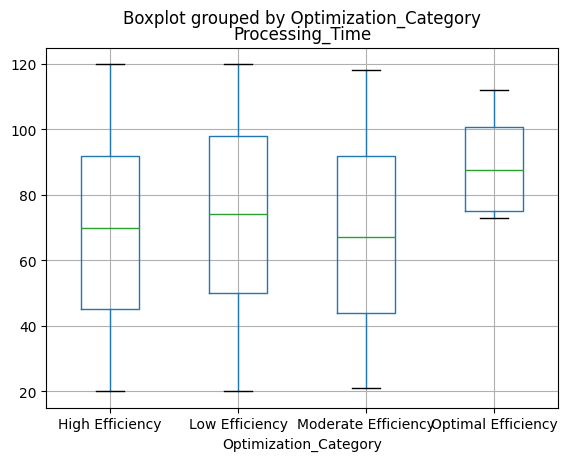

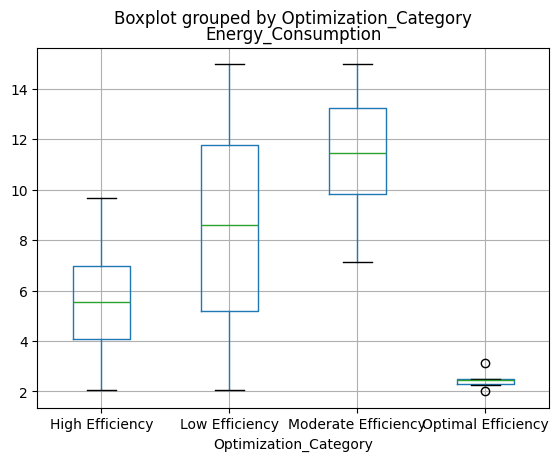

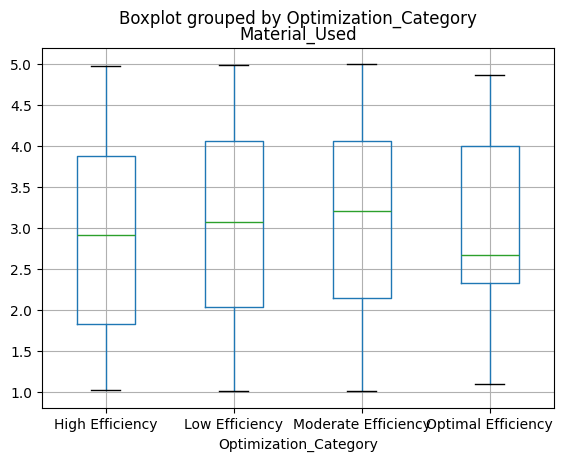

In [63]:
# Optimization_Category(최적화 범주)에 따른 수치형 컬럼들의 평균, 분포 시각화
for col in ["Processing_Time", "Energy_Consumption", "Material_Used"]:
    df.boxplot(column=col, by="Optimization_Category")

## Optimization_Category별 주요 특성 비교

### 관찰 결과
- **Optimal Efficiency**
  - 다른 범주 대비 평균 **Processing Time**이 상대적으로 김

- **Moderate Efficiency**
  - 평균 **Energy Consumption**과 **Material Used**가 상대적으로 높음

- **Material Used**
  - Optimization_Category에 따른 평균 차이가 크지 않음

### 정리
**최적 효율(Optimal Efficiency)**
은 처리 시간이 길어지는 경향이 있으며,
**중간 효율(Moderate Efficiency)**
은 자원 소모가 큼

**생산 일정이 촉박한 경우**에는 '최적 효율'보다 **처리 시간 단축**이 가능한 전략을 우선 고려할 필요

In [66]:
# 1-2. Machine_ID(기계 식별자)별로 Optimization_Category(최적화 범주) 확인
df.groupby('Machine_ID')['Optimization_Category'].value_counts()

Machine_ID  Optimization_Category
M01         Low Efficiency           128
            Moderate Efficiency       43
            High Efficiency           40
            Optimal Efficiency         1
M02         Low Efficiency           137
            High Efficiency           40
            Moderate Efficiency       32
            Optimal Efficiency         1
M03         Low Efficiency           120
            Moderate Efficiency       40
            High Efficiency           26
M04         Low Efficiency           129
            Moderate Efficiency       35
            High Efficiency           32
            Optimal Efficiency         3
M05         Low Efficiency           136
            Moderate Efficiency       33
            High Efficiency           23
            Optimal Efficiency         1
Name: count, dtype: int64

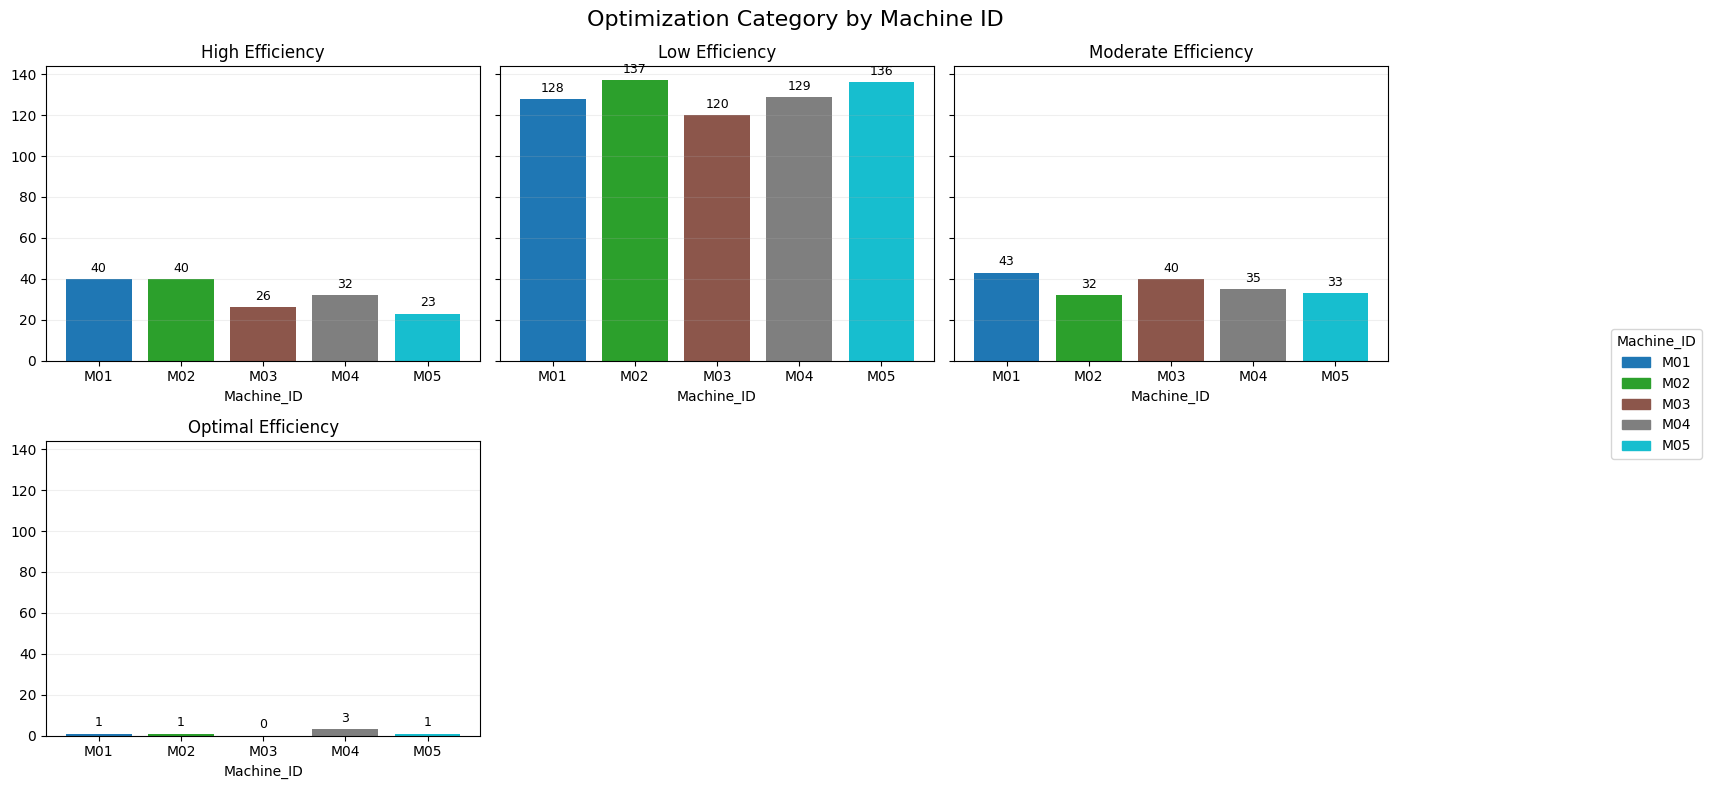

In [132]:
# Machine_ID(기계 식별자)별로 Optimization_Category(최적화 범주) 시각화
fig.suptitle("Optimization Category by Machine ID", fontsize=16)
# 1) 집계
ct = pd.crosstab(df["Optimization_Category"], df["Machine_ID"])

ops = ct.index.tolist()
machines = ct.columns.tolist()

# 2) subplot 레이아웃 자동 (공정 개수에 따라)
n_ops = len(ops)
ncols = 3
nrows = int(np.ceil(n_ops / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows), sharey=True)
axes = np.array(axes).reshape(-1)

# 3) Machine_ID별 색상 고정 (모든 subplot에서 동일 색)
cmap = plt.get_cmap("tab10", len(machines))
color_map = {m: cmap(i) for i, m in enumerate(machines)}

# 4) 공정별 bar 그리기
fig.suptitle("Optimization Category by Machine ID", fontsize=16)
for i, op in enumerate(ops):
    ax = axes[i]
    s = ct.loc[op]  # Machine_ID별 count (Series)

    bars = ax.bar(
        s.index.astype(str),
        s.values,
        color=[color_map[m] for m in s.index]
    )

    ax.set_title(op)
    ax.set_xlabel("Machine_ID")
    ax.grid(axis="y", alpha=0.2)

    # (3) 막대 위에 수치 표시
    ax.bar_label(bars, padding=3, fontsize=9)

# 남는 subplot 비우기
for j in range(n_ops, len(axes)):
    fig.delaxes(axes[j])

# (2) 범례를 그래프 밖(오른쪽)으로
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[m]) for m in machines]
labels = [str(m) for m in machines]
fig.legend(
    handles, labels, title="Machine_ID",
    loc="center left", bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0
)
plt.tight_layout(rect=[0, 0, 0.88, 1])  # 오른쪽 범례 공간 확보
plt.show()

## Machine_ID별 Optimization_Category 분포 분석

### 관찰 결과
- Machine_ID 기준으로 Optimization_Category(최적화 범주)가 뚜렷하게 구분되지 않음
- 대부분의 기계가 **Low Efficiency** 범주에 집중됨
- Low Efficiency를 제외한 나머지 범주는 기계별로 거의 균등하게 분포

### 정리
- Optimization_Category(최적화 범주) 단독으로는 기계별 성능 차이를 구분하는 데 한계가 있음

In [72]:
# 2. Actual_Start ~ Actual_End에 있는 결측치 원인 파악 및 처리 여부
# Actual_Start의 비결측값/결측값
df["Actual_Start"].isna().value_counts()

Actual_Start
False    871
True     129
Name: count, dtype: int64

In [71]:
# Actual_End의 비결측값/결측값
df["Actual_End"].isna().value_counts()

Actual_End
False    871
True     129
Name: count, dtype: int64

In [82]:
# Actual_Start와 Actual_End의 비결측값/결측값이 일치하므로 Actual_Start를 기준으로 결측치 원인 파악 및 처리 여부
df[df["Actual_Start"].isna()]

,Job_ID,Machine_ID,Operation_Type,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability,Scheduled_Start,Scheduled_End,Actual_Start,Actual_End,Job_Status,Optimization_Category,Actual_Start_is_null
2,J003,M04,Additive,2.29,56,11.11,92,2023-03-18 8:20,2023-03-18 9:16,NaN,NaN,Failed,Low Efficiency,True
24,J025,M04,Lathe,1.84,119,5.10,82,2023-03-18 12:00,2023-03-18 13:59,NaN,NaN,Failed,Low Efficiency,True
26,J027,M03,Lathe,4.03,87,11.34,80,2023-03-18 12:20,2023-03-18 13:47,NaN,NaN,Failed,Low Efficiency,True
38,J039,M02,Drilling,4.06,48,10.65,86,2023-03-18 14:20,2023-03-18 15:08,NaN,NaN,Failed,Low Efficiency,True
50,J051,M04,Lathe,4.25,24,7.26,90,2023-03-18 16:20,2023-03-18 16:44,NaN,NaN,Failed,Low Efficiency,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,J977,M01,Milling,1.73,78,7.00,93,2023-03-25 2:40,2023-03-25 3:58,NaN,NaN,Failed,Low Efficiency,True
979,J980,M03,Additive,4.16,71,12.30,84,2023-03-25 3:10,2023-03-25 4:21,NaN,NaN,Failed,Low Efficiency,True
994,J995,M03,Drilling,4.37,118,14.12,88,2023-03-25 5:40,2023-03-25 7:38,NaN,NaN,Failed,Low Efficiency,True
995,J996,M02,Milling,4.86,50,3.71,97,2023-03-25 5:50,2023-03-25 6:40,NaN,NaN,Failed,Low Efficiency,True


In [83]:
# Actual_Start 컬럼의 결측 여부를 식별하기 위한 파생 컬럼 생성
df["Actual_Start_is_null"] = df["Actual_Start"].isna()

In [84]:
# Actual_Start에 따른 Job_Status 파악
df.groupby('Actual_Start_is_null')['Job_Status'].value_counts()

Actual_Start_is_null  Job_Status
False                 Completed     673
                      Delayed       198
True                  Failed        129
Name: count, dtype: int64

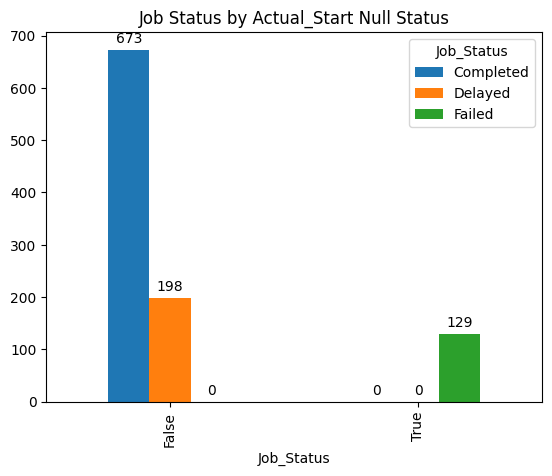

In [124]:
# Actual_Start에 따른 Job_Status 시각화
job_status_by_actual_start_null = pd.crosstab(
    df["Actual_Start_is_null"],
    df["Job_Status"]
)
job_status_ax = job_status_by_actual_start_null.plot(kind="bar")
plt.title("Job Status by Actual_Start Null Status")
plt.xlabel("Job_Status")

for container in job_status_ax.containers:
    job_status_ax.bar_label(container, padding=3)
    
plt.show()

In [115]:
# Actual_Start에 따라 Optimization_Category 영향을 미치는지 파악
Optimization_Category_count_by_actual_start_null = (
    df[df["Actual_Start_is_null"]]["Optimization_Category"]
    .value_counts()
)
Optimization_Category_count_by_actual_start_null

Optimization_Category
Low Efficiency    129
Name: count, dtype: int64

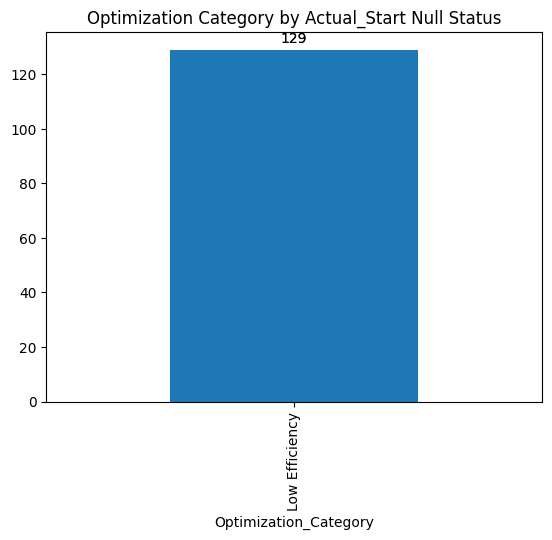

In [123]:
# Actual_Start에 따라 Optimization_Category 영향 시각화 
Optimization_Category_count_by_actual_start_null.plot(kind="bar")

Optimization_Category_ax = Optimization_Category_count_by_actual_start_null.plot(kind="bar")
plt.title("Optimization Category by Actual_Start Null Status")
plt.xlabel("Optimization_Category")

for container in Optimization_Category_ax.containers:
    Optimization_Category_ax.bar_label(container, padding=3)
    
plt.show()

## Actual_Start / Actual_End 결측치 분석

### 관찰 결과
- Actual_Start ~ Actual_End 결측치는 **Job_Status가 `Failed`인 경우에만 발생**
- 해당 결측치는 모두 **Optimization_Category = Low Efficiency**에 해당

### 정리
- **작업 실패(Failed)**
로 인해 실제 작업이 수행되지 않아 시작·종료 시간이 기록되지 않은 것으로 판단됨

### 처리
- 해당 결측치는 **데이터 오류가 아닌 의미 있는 상태값**으로 간주
- 분석 목적에 따라 **결측값을 유지**하고 활용

## EDA 결과 요약 및 분석 방향 조정

초기에는 수치형 변수 간 상관관계 분석을 통해
생산 효율성에 영향을 미치는 주요 요인을 탐색

다만 본 데이터는 **분포가 비교적 안정적이고 극단값이 적어**,
변수 간 유의미한 상관관계를 도출하는 데에는 한계가 있음

이에 따라 분석 방향을 조정하여,
개별 변수 간의 관계 분석보다는
데이터 특성을 반영한 **주제별 요약 및 집계 중심의 분석**으로 전환

해당 접근 방식은 Gold 단계에서
**기계·공정·작업 상태 기준**의 KPI 설계 및 시각화 적합하다고 판단